# ECS7026P Neural Networks and Deep Learning - 2022/23 : Coursework 1


    Name: Mohammed Ataaur Rahaman
    Student Number: 220843052
    email: m.a.rahaman@se22.qmul.ac.uk
    Assignment Number: Coursework 1
    Module Code: ECS6P9U/P/7026P
    Module Name: Neural Networks and Deep Learning 

Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

from torch import nn
from tqdm.auto import tqdm

In [2]:
!nvidia-smi

Sat Apr  8 20:27:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:17:00.0 Off |                    0 |
|  0%   59C    P0   133W / 300W |      0MiB /  5067MiB |     16%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Gathering

In [3]:
# Transformations type : https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_train_1 = transforms.Compose([
    transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
    transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
    transforms.RandomRotation(10),     #Rotates the image to a specified angel
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
    transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
])
 
transform_train_2 = transforms.Compose([
    #transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=[32,32], padding=4),
    transforms.RandomRotation(degrees=(-10, 10)),
    #transforms.RandomAdjustSharpness(sharpness_factor=2),
    #transforms.RandomResizedCrop(size=(32, 32)),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
])

In [4]:
transform_train = transform_train_2

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# transform = transforms.Compose([transforms.ToTensor()])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

In [6]:
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

In [7]:
testset, trainset

(Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ),
 Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomHorizontalFlip(p=0.5)
                RandomCrop(size=(32, 32), padding=4)
                RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ))

## Data Preprocessing

In [8]:
BATCH_SIZE = 8
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

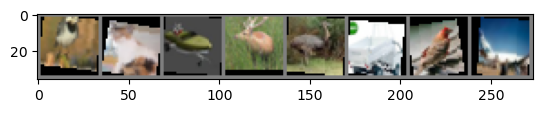

bird  cat   ship  deer  bird  truck bird  plane


In [9]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{CLASSES[labels[j]]:5s}' for j in range(BATCH_SIZE)))


In [10]:
# print size of data in batch

for d in trainloader:
    print(d[0].shape)
    break

torch.Size([8, 3, 32, 32])


## Model

In [77]:
# Parameters 


N = 2
IMG_DIM = 32
IMG_CHANNELS = 3
HIDDEN_CHANNELS = 16
HIDDEN_CONV_KERNEL = 5
STRIDE = 1

In [78]:
class ConvBlock(nn.Sequential):

    def __init__(self, in_channels=IMG_CHANNELS, out_channels=HIDDEN_CHANNELS, kernel_size=HIDDEN_CONV_KERNEL):
        
        super(ConvBlock, self).__init__(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            #nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            #nn.Dropout2d(p=0.5),
        )

In [79]:
class Backbone(nn.Module):

    def __init__(self, in_channels=IMG_CHANNELS, out_channels=HIDDEN_CHANNELS, kernel_size=HIDDEN_CONV_KERNEL, k=5, debug=False):
        super(Backbone, self).__init__()

        # Boolean to print debug logs.
        self.debug = debug

        self.spaitial_average_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        self.linear = nn.Sequential(
            nn.Linear(in_features=in_channels, out_features=k, bias=False),   # Question, can this be MLP?
            #nn.Tanh(),
            # nn.LeakyReLU(),
            # nn.Linear(in_features=k, out_features=k, bias=True),  
            #nn.ReLU(),
            nn.Sigmoid(),      # Non Linear Activation
        )

        self.conv_blocks = nn.ModuleList([
            ConvBlock(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size)
            for _ in range(k)
        ])

        self.batch_norm = nn.BatchNorm2d(num_features=out_channels)

    def forward(self, x):
        sap_out = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
        if self.debug: print(f"{sap_out.shape=}")

        g_out = self.linear(sap_out)
        if self.debug: print(f"{g_out.shape=}")
        if self.debug: print(f"{g_out=}")

        outs = list()
        for a, conv_block in zip(g_out.transpose(0, 1), self.conv_blocks):
        #for conv2d in self.conv2ds:
            c_out = conv_block(x)
            if self.debug: print(f"{c_out.shape=}")
            if self.debug: print(f"{a.shape=}, \n{a=}")

            out = a.reshape(x.shape[0], 1, 1, 1)*c_out
            if self.debug: print(f"{out.shape=}")
            outs.append(out)
            #outs.append(c_out)

        out = sum(outs)
        if self.debug: print(f"{out.shape=}")

        #out = self.batch_norm(out)
        #if self.debug: print(f"batch_{out.shape=}")

        return out

In [80]:
class Classifier(nn.Module):
    
    def __init__(self, in_features, out_features, debug=True):
        
        super(Classifier, self).__init__()
        self.debug = debug
        
        self.spaitial_average_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        
        self.mlp = nn.Sequential(
            #nn.Linear(in_features=in_features, out_features=in_features * 2 // 3, bias=False),
            #nn.Dropout(p=0.2),
            #nn.ReLU(),
            #nn.Linear(in_features=in_features * 2 // 3, out_features=in_features // 3, bias=False),
            #nn.Dropout(p=0.2),
            #nn.ReLU(),
            #nn.Linear(in_features=in_features // 3, out_features=len(CLASSES), bias=False),
            nn.Linear(in_features=in_features, out_features=out_features, bias=True),
        )
        
    def forward(self, x):
        
        f = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
        if self.debug: print(f"Classifier: {f.shape=}")

        out = self.mlp(f)
        if self.debug: print(f"Classifier: {out.shape=}")

        return out

In [81]:
class Model(nn.Module):
    
    def __init__(self, channels, Ks, kernel_size=HIDDEN_CONV_KERNEL, n=N, debug=False):
        
        super(Model, self).__init__()
        
        self.debug = debug   # Boolean to print debug logs.
        self.Ks = Ks
        self.channels = channels
        self.n = n

        self.backbones = nn.ModuleList([
            Backbone(
                in_channels=self.channels[i], 
                out_channels=self.channels[i+1], 
                kernel_size=kernel_size, 
                k=self.Ks[i], 
                debug=debug
            ) 
            for i in range(self.n)
        ])
        
        self.classifier = Classifier(in_features=self.channels[-1], out_features=len(CLASSES), debug=debug)

    def set_debug(self, debug=True):
        
        self.debug = debug
        for backbone in self.backbones:
            backbone.debug = debug
        self.classifier.debug = debug

    def forward(self, x):
        
        for backbone in self.backbones:
            x = backbone(x)
    
        out = self.classifier(x)

        return out

In [82]:
class Trainer:
    
    def __init__(self, model, criterion, optimizer, scheduler, trainloader, testloader, logs_per_epoch=4) -> None:
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        
        self.epochs = 0
        self.log_step = len(trainloader) // logs_per_epoch

        self.trainloader = trainloader
        self.testloader = testloader
        
        self.lrs = list()
        self.losses = list()
        self.val_losses = list()
        self.batch_losses = list()

        self.train_accuracy = list()
        self.val_accuracy = list()
        
    
    def train(self, epochs=3, use_gpu=False):
        
        for epoch in range(self.epochs, self.epochs + epochs):  # loop over the dataset multiple times

            batch_losses = list()
            running_loss = 0.0
            correct = 0
            total = 0
        
            self.model.train()
            
            for i, data in tqdm(enumerate(self.trainloader, 0), total=len(trainloader), desc=f"Epoch {epoch + 1} "):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                if use_gpu:
                    inputs = inputs.to('cuda')
                    labels = labels.to('cuda')

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                
                # Accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # print statistics
                batch_losses.append(loss.item())
                running_loss += loss.item()
                if i % self.log_step == self.log_step-1:    # print every 2000 mini-batches
                    avg_loss = running_loss / self.log_step
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}')
                    running_loss = 0.0
                    self.batch_losses.append(avg_loss)

            self.losses.append(sum(batch_losses) / len(batch_losses))
            print(f"Train Loss : {self.losses[-1]}")
            
            accuracy = correct / total
            self.train_accuracy.append(accuracy)
            print(f'Train Accuracy : {100 * accuracy:.2f} %')
            
            # Save Learning rate.
            #print(f"{self.scheduler.get_last_lr()=}")
            #print(f"{self.optimizer.param_groups[0]['lr']=}")
            self.lrs.append(self.optimizer.param_groups[0]['lr'])
            
            self.eval()
            self.scheduler.step()

        self.epochs += epochs
        print('Finished Training')
    
    
    def eval(self):
        correct = 0
        total = 0
        losses = list()
        
        self.model.eval()
        
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in self.testloader:
                images, labels = data
                if USE_GPU:
                    images = images.to('cuda')
                    labels = labels.to('cuda')

                # calculate outputs by running images through the network
                outputs = self.model(images)

                loss = self.criterion(outputs, labels)
                losses.append(loss.item())

                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()


        val_loss = sum(losses) / len(losses)
        self.val_losses.append(val_loss)

        print(f"Val Loss : {val_loss}")

        accuracy = correct / total
        self.val_accuracy.append(accuracy)
        print(f'Accuracy of the network on the 10000 test images: {100 * accuracy:.2f} %')
    
    def plot(self):
        fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
        fig.set_size_inches(15, 3)
        
        epochs_x = range(1, self.epochs+1)
        
        ax0.plot(epochs_x, self.lrs, label="LR", color='C3', lw=3, alpha=1)
        ax0.legend()
        ax0.set_yscale('log')
        ax0.set(title=f'Learning Rates', xlabel='Epoch', ylabel='Learning rate')

        X = np.linspace(1, len(self.losses), len(self.batch_losses))
        ax1.plot(X, self.batch_losses, label="Train Batches", color='C0', linestyle='dashed', lw=1, alpha=0.7)
        ax1.plot(epochs_x, self.losses, label='Train', color='C0', lw=3, alpha=1)
        ax1.plot(epochs_x, self.val_losses, label='Test', color='C1', lw=3, alpha=1)
        ax1.legend()
        ax1.set(title=f'Loss Curve', xlabel='Epoch', ylabel='Loss')
        
        ax2.plot(epochs_x, self.train_accuracy, label="Train", color='C0', lw=3, alpha=1)
        ax2.plot(epochs_x, self.val_accuracy, label="Test", color='C1', lw=3, alpha=1)
        ax2.set(title=f'Accuracy Curve', xlabel='Epoch', ylabel='Accuracy')
        ax2.legend()
        plt.tight_layout()
        fig.show()
    

In [83]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d: # by checking the type we can init different layers in different ways
        torch.nn.init.xavier_uniform_(m.weight)   

In [84]:
def model_summary(model, trainloader):

    img_sizes = list()
    
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            if USE_GPU:
                images = images.to('cuda')
                labels = labels.to('cuda')
            
            x = images
            
            img_sizes.append(x.shape[-1])
            for backbone in model.backbones:
                x = backbone(x)
                img_sizes.append(x.shape[-1])
            break
                
    print(f"{model.channels=}")
    print(f"{model.Ks=}")
    print(f"{model.n=}")
    print(f"{img_sizes=}")

## Experiment

In [85]:
# Init model

IMG_DIM = 32
IMG_CHANNELS = 3
USE_GPU = True


# K = 5
# HIDDEN_CHANNELS = 16
HIDDEN_CONV_KERNEL = 3
STRIDE = 1

# channels = [IMG_CHANNELS, 16, 32, 64, 64] #20, 25, 30]
# channels = [IMG_CHANNELS, 4, 8, 16, ]
# channels = [IMG_CHANNELS, 5, 7, 9, 11, 13]
channels = [IMG_CHANNELS, 64, 128, 256, 512, 1028] 
# Ks = channels[1:]
Ks = [3] * (len(channels) - 1)
N = len(channels) - 1

model = Model(
    Ks=Ks,
    channels=channels,
    kernel_size=HIDDEN_CONV_KERNEL, 
    n=N, 
    debug=True
)

model.apply(init_weights)

if USE_GPU: model.to('cuda')
model.set_debug(False)
model_summary(model=model, trainloader=trainloader)
model

model.channels=[3, 64, 128, 256, 512]
model.Ks=[3, 3, 3, 3]
model.n=4
img_sizes=[32, 16, 8, 4, 2]


Model(
  (backbones): ModuleList(
    (0): Backbone(
      (spaitial_average_pool): AdaptiveAvgPool2d(output_size=(1, 1))
      (linear): Sequential(
        (0): Linear(in_features=3, out_features=3, bias=False)
        (1): Sigmoid()
      )
      (conv_blocks): ModuleList(
        (0): ConvBlock(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (1): ConvBlock(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (2): ConvBlock(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(

In [104]:
# Init optimizer 

LR = 1e-3 #1e-3, 1e-4
LR_STEP_SIZE = 10
WEIGHT_DECAY = 0.05 # 0.15


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=LR_STEP_SIZE, gamma=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=2, step_size_down=None, mode='triangular', gamma=1.0, scale_fn=None, scale_mode='cycle', cycle_momentum=False, base_momentum=0.8, max_momentum=0.9, last_epoch=- 1, verbose=False)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-5, eps=1e-08, verbose=False)

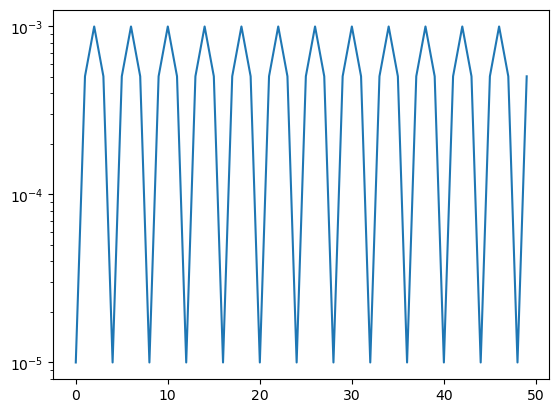

In [103]:
lrs_ = list()
for i in range(50):
    optimizer.step()
    scheduler.step(i)
    #lrs_.append(scheduler.get_last_lr())
    lrs_.append(optimizer.param_groups[0]['lr'])
    
fig, ax = plt.subplots(1)
ax.plot(lrs_)
ax.set_yscale('log')

In [105]:
# Init Trainer

BATCH_SIZE = 256

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


trainer = Trainer(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    logs_per_epoch=4,
    trainloader=trainloader,
    testloader=testloader,
)

Epoch 1 :   0%|          | 0/196 [00:00<?, ?it/s]

[1,    49] loss: 2.222
[1,    98] loss: 1.866
[1,   147] loss: 1.757
[1,   196] loss: 1.668
Train Loss : 1.8782545370715005
Train Accuracy : 32.83 %
Val Loss : 1.694149088859558
Accuracy of the network on the 10000 test images: 38.47 %


Epoch 2 :   0%|          | 0/196 [00:00<?, ?it/s]

[2,    49] loss: 1.571
[2,    98] loss: 1.358
[2,   147] loss: 1.257
[2,   196] loss: 1.190
Train Loss : 1.3440470823219843
Train Accuracy : 51.62 %
Val Loss : 1.4032467693090438
Accuracy of the network on the 10000 test images: 50.66 %


Epoch 3 :   0%|          | 0/196 [00:00<?, ?it/s]

[3,    49] loss: 1.210
[3,    98] loss: 1.124
[3,   147] loss: 1.062
[3,   196] loss: 1.017
Train Loss : 1.1028282697103462
Train Accuracy : 60.99 %
Val Loss : 1.0170175909996033
Accuracy of the network on the 10000 test images: 64.44 %


Epoch 4 :   0%|          | 0/196 [00:00<?, ?it/s]

[4,    49] loss: 0.923
[4,    98] loss: 0.869
[4,   147] loss: 0.842
[4,   196] loss: 0.829
Train Loss : 0.8654575028589794
Train Accuracy : 69.52 %
Val Loss : 0.8858671888709069
Accuracy of the network on the 10000 test images: 69.01 %


Epoch 5 :   0%|          | 0/196 [00:00<?, ?it/s]

[5,    49] loss: 0.772
[5,    98] loss: 0.740
[5,   147] loss: 0.753
[5,   196] loss: 0.734
Train Loss : 0.7496909909710592
Train Accuracy : 73.62 %
Val Loss : 0.6981351479887963
Accuracy of the network on the 10000 test images: 75.59 %


Epoch 6 :   0%|          | 0/196 [00:00<?, ?it/s]

[6,    49] loss: 0.808
[6,    98] loss: 0.821
[6,   147] loss: 0.781
[6,   196] loss: 0.777
Train Loss : 0.7967237672027276
Train Accuracy : 71.98 %
Val Loss : 1.179260514676571
Accuracy of the network on the 10000 test images: 63.66 %


Epoch 7 :   0%|          | 0/196 [00:00<?, ?it/s]

[7,    49] loss: 0.845
[7,    98] loss: 0.825
[7,   147] loss: 0.814
[7,   196] loss: 0.788
Train Loss : 0.8182170156921659
Train Accuracy : 71.57 %
Val Loss : 0.8486544251441955
Accuracy of the network on the 10000 test images: 71.53 %


Epoch 8 :   0%|          | 0/196 [00:00<?, ?it/s]

[8,    49] loss: 0.692
[8,    98] loss: 0.663
[8,   147] loss: 0.674
[8,   196] loss: 0.669
Train Loss : 0.6744654802035313
Train Accuracy : 76.40 %
Val Loss : 0.9290992006659508
Accuracy of the network on the 10000 test images: 68.30 %


Epoch 9 :   0%|          | 0/196 [00:00<?, ?it/s]

[9,    49] loss: 0.624
[9,    98] loss: 0.583
[9,   147] loss: 0.584
[9,   196] loss: 0.574
Train Loss : 0.5911637914119935
Train Accuracy : 79.42 %
Val Loss : 0.5608903028070926
Accuracy of the network on the 10000 test images: 80.58 %


Epoch 10 :   0%|          | 0/196 [00:00<?, ?it/s]

[10,    49] loss: 0.623
[10,    98] loss: 0.638
[10,   147] loss: 0.657
[10,   196] loss: 0.636
Train Loss : 0.6385889022934194
Train Accuracy : 77.64 %
Val Loss : 0.9563179805874824
Accuracy of the network on the 10000 test images: 69.99 %


Epoch 11 :   0%|          | 0/196 [00:00<?, ?it/s]

[11,    49] loss: 0.706
[11,    98] loss: 0.680
[11,   147] loss: 0.689
[11,   196] loss: 0.685
Train Loss : 0.6898011489182102
Train Accuracy : 75.82 %
Val Loss : 0.9013076201081276
Accuracy of the network on the 10000 test images: 70.22 %


Epoch 12 :   0%|          | 0/196 [00:00<?, ?it/s]

[12,    49] loss: 0.597
[12,    98] loss: 0.576
[12,   147] loss: 0.575
[12,   196] loss: 0.549
Train Loss : 0.5741201680229635
Train Accuracy : 79.99 %
Val Loss : 0.6884742490947247
Accuracy of the network on the 10000 test images: 76.54 %


Epoch 13 :   0%|          | 0/196 [00:00<?, ?it/s]

[13,    49] loss: 0.527
[13,    98] loss: 0.490
[13,   147] loss: 0.482
[13,   196] loss: 0.483
Train Loss : 0.49528278227971523
Train Accuracy : 83.00 %
Val Loss : 0.4963125132024288
Accuracy of the network on the 10000 test images: 83.27 %


Epoch 14 :   0%|          | 0/196 [00:00<?, ?it/s]

[14,    49] loss: 0.524
[14,    98] loss: 0.544
[14,   147] loss: 0.526
[14,   196] loss: 0.552
Train Loss : 0.5364237155537216
Train Accuracy : 81.27 %
Val Loss : 0.85613182336092
Accuracy of the network on the 10000 test images: 72.30 %


Epoch 15 :   0%|          | 0/196 [00:00<?, ?it/s]

[15,    49] loss: 0.593
[15,    98] loss: 0.613
[15,   147] loss: 0.583
[15,   196] loss: 0.617
Train Loss : 0.6014098476390449
Train Accuracy : 78.80 %
Val Loss : 0.8899761661887169
Accuracy of the network on the 10000 test images: 69.74 %


Epoch 16 :   0%|          | 0/196 [00:00<?, ?it/s]

[16,    49] loss: 0.523
[16,    98] loss: 0.495
[16,   147] loss: 0.492
[16,   196] loss: 0.486
Train Loss : 0.4993024666090401
Train Accuracy : 82.67 %
Val Loss : 0.5854059286415577
Accuracy of the network on the 10000 test images: 80.84 %


Epoch 17 :   0%|          | 0/196 [00:00<?, ?it/s]

[17,    49] loss: 0.436
[17,    98] loss: 0.437
[17,   147] loss: 0.415
[17,   196] loss: 0.422
Train Loss : 0.4274790908913223
Train Accuracy : 85.19 %
Val Loss : 0.4528061479330063
Accuracy of the network on the 10000 test images: 84.74 %


Epoch 18 :   0%|          | 0/196 [00:00<?, ?it/s]

[18,    49] loss: 0.463
[18,    98] loss: 0.492
[18,   147] loss: 0.457
[18,   196] loss: 0.475
Train Loss : 0.47185445227185074
Train Accuracy : 83.65 %
Val Loss : 0.7546007350087166
Accuracy of the network on the 10000 test images: 74.71 %


Epoch 19 :   0%|          | 0/196 [00:00<?, ?it/s]

[19,    49] loss: 0.513
[19,    98] loss: 0.532
[19,   147] loss: 0.565
[19,   196] loss: 0.551
Train Loss : 0.5403400452769532
Train Accuracy : 81.29 %
Val Loss : 0.6975501671433448
Accuracy of the network on the 10000 test images: 76.14 %


Epoch 20 :   0%|          | 0/196 [00:00<?, ?it/s]

[20,    49] loss: 0.459
[20,    98] loss: 0.433
[20,   147] loss: 0.442
[20,   196] loss: 0.442
Train Loss : 0.44414037055507
Train Accuracy : 84.58 %
Val Loss : 0.5549297288060189
Accuracy of the network on the 10000 test images: 81.56 %
Finished Training


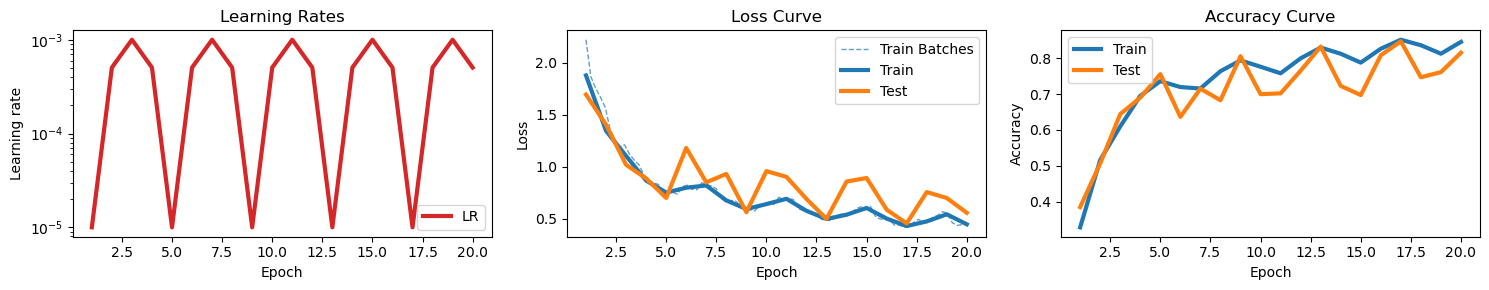

In [106]:
trainer.train(epochs=20, use_gpu=USE_GPU)
trainer.plot()

In [ ]:
trainer.train(epochs=20, use_gpu=USE_GPU)
trainer.plot()

Epoch 21 :   0%|          | 0/196 [00:00<?, ?it/s]

[21,    49] loss: 0.403
[21,    98] loss: 0.367
[21,   147] loss: 0.371
[21,   196] loss: 0.362
Train Loss : 0.37600016198596176
Train Accuracy : 86.97 %
Val Loss : 0.4205304279923439
Accuracy of the network on the 10000 test images: 85.90 %


Epoch 22 :   0%|          | 0/196 [00:00<?, ?it/s]

[22,    49] loss: 0.422
[22,    98] loss: 0.414
[22,   147] loss: 0.418
[22,   196] loss: 0.425
Train Loss : 0.4197314986769034
Train Accuracy : 85.36 %
Val Loss : 0.6119723863899708
Accuracy of the network on the 10000 test images: 81.18 %


Epoch 23 :   0%|          | 0/196 [00:00<?, ?it/s]

[23,    49] loss: 0.486
[23,    98] loss: 0.493
[23,   147] loss: 0.493
[23,   196] loss: 0.502
Train Loss : 0.4935298355258241
Train Accuracy : 82.96 %
Val Loss : 0.7772460803389549
Accuracy of the network on the 10000 test images: 76.00 %


Epoch 24 :   0%|          | 0/196 [00:00<?, ?it/s]

[24,    49] loss: 0.420
[24,    98] loss: 0.391
[24,   147] loss: 0.397
[24,   196] loss: 0.390
Train Loss : 0.39937120964940714
Train Accuracy : 85.97 %
Val Loss : 0.4862354189157486
Accuracy of the network on the 10000 test images: 83.89 %


Epoch 25 :   0%|          | 0/196 [00:00<?, ?it/s]

[25,    49] loss: 0.355
[25,    98] loss: 0.349
[25,   147] loss: 0.323
[25,   196] loss: 0.328
Train Loss : 0.33879640668022387
Train Accuracy : 88.42 %
Val Loss : 0.40583461299538615
Accuracy of the network on the 10000 test images: 86.39 %


Epoch 26 :   0%|          | 0/196 [00:00<?, ?it/s]

[26,    49] loss: 0.372
[26,    98] loss: 0.378
[26,   147] loss: 0.376
[26,   196] loss: 0.383
Train Loss : 0.3772841155224917
Train Accuracy : 86.94 %
Val Loss : 0.6226061210036278
Accuracy of the network on the 10000 test images: 80.10 %


Epoch 27 :   0%|          | 0/196 [00:00<?, ?it/s]

[27,    49] loss: 0.446
[27,    98] loss: 0.448
[27,   147] loss: 0.450
[27,   196] loss: 0.454
Train Loss : 0.44935609111372304
Train Accuracy : 84.22 %
Val Loss : 0.5601811900734901
Accuracy of the network on the 10000 test images: 80.62 %


Epoch 28 :   0%|          | 0/196 [00:00<?, ?it/s]

[28,    49] loss: 0.360
[28,    98] loss: 0.358
[28,   147] loss: 0.373
[28,   196] loss: 0.359
Train Loss : 0.3625770708432003
Train Accuracy : 87.32 %
Val Loss : 0.47977499291300774
Accuracy of the network on the 10000 test images: 83.83 %


Epoch 29 :   0%|          | 0/196 [00:00<?, ?it/s]

[29,    49] loss: 0.308
[29,    98] loss: 0.295
[29,   147] loss: 0.285
[29,   196] loss: 0.288
Train Loss : 0.2939455830016915
Train Accuracy : 89.75 %
Val Loss : 0.3779923155903816
Accuracy of the network on the 10000 test images: 87.16 %


Epoch 30 :   0%|          | 0/196 [00:00<?, ?it/s]

[30,    49] loss: 0.325
[30,    98] loss: 0.333
[30,   147] loss: 0.357
[30,   196] loss: 0.341
Train Loss : 0.33924564141400004
Train Accuracy : 88.20 %
Val Loss : 0.6761738754808903
Accuracy of the network on the 10000 test images: 79.50 %


Epoch 31 :   0%|          | 0/196 [00:00<?, ?it/s]

[31,    49] loss: 0.387
[31,    98] loss: 0.418
[31,   147] loss: 0.431
[31,   196] loss: 0.417
Train Loss : 0.4131112509236044
Train Accuracy : 85.56 %
Val Loss : 0.8206984430551529
Accuracy of the network on the 10000 test images: 75.33 %


Epoch 32 :   0%|          | 0/196 [00:00<?, ?it/s]

[32,    49] loss: 0.337
[32,    98] loss: 0.329
[32,   147] loss: 0.340
[32,   196] loss: 0.317
Train Loss : 0.33070668334863623
Train Accuracy : 88.31 %
Val Loss : 0.49237618669867517
Accuracy of the network on the 10000 test images: 84.03 %


Epoch 33 :   0%|          | 0/196 [00:00<?, ?it/s]

[33,    49] loss: 0.271
[33,    98] loss: 0.267
[33,   147] loss: 0.269
[33,   196] loss: 0.267
Train Loss : 0.26840987421420154
Train Accuracy : 90.77 %
Val Loss : 0.3666577719151974
Accuracy of the network on the 10000 test images: 87.81 %


Epoch 34 :   0%|          | 0/196 [00:00<?, ?it/s]

[34,    49] loss: 0.289
[34,    98] loss: 0.311
[34,   147] loss: 0.310
[34,   196] loss: 0.317
Train Loss : 0.30686243775547767
Train Accuracy : 89.39 %
Val Loss : 0.4917441725730896
Accuracy of the network on the 10000 test images: 84.14 %


Epoch 35 :   0%|          | 0/196 [00:00<?, ?it/s]

[35,    49] loss: 0.350
[35,    98] loss: 0.407
[35,   147] loss: 0.388
[35,   196] loss: 0.400
Train Loss : 0.38643501881433995
Train Accuracy : 86.48 %
Val Loss : 0.6854436412453652
Accuracy of the network on the 10000 test images: 78.73 %


Epoch 36 :   0%|          | 0/196 [00:00<?, ?it/s]

[36,    49] loss: 0.310
[36,    98] loss: 0.294
[36,   147] loss: 0.286
[36,   196] loss: 0.288
Train Loss : 0.2946718322227196
Train Accuracy : 89.62 %
Val Loss : 0.4626984417438507
Accuracy of the network on the 10000 test images: 85.40 %


Epoch 37 :   0%|          | 0/196 [00:00<?, ?it/s]

[37,    49] loss: 0.259
[37,    98] loss: 0.238
[37,   147] loss: 0.234
[37,   196] loss: 0.240
Train Loss : 0.24296089946007243
Train Accuracy : 91.67 %
Val Loss : 0.35734280943870544
Accuracy of the network on the 10000 test images: 88.42 %


Epoch 38 :   0%|          | 0/196 [00:00<?, ?it/s]

[38,    49] loss: 0.265
[38,    98] loss: 0.267
[38,   147] loss: 0.279
[38,   196] loss: 0.290
Train Loss : 0.2754120932397794
Train Accuracy : 90.28 %
Val Loss : 0.5230357505381107
Accuracy of the network on the 10000 test images: 83.91 %


Epoch 39 :   0%|          | 0/196 [00:00<?, ?it/s]

[39,    49] loss: 0.334
[39,    98] loss: 0.359
[39,   147] loss: 0.378
[39,   196] loss: 0.375
Train Loss : 0.36136744657949527
Train Accuracy : 87.10 %
Val Loss : 0.5008613504469395
Accuracy of the network on the 10000 test images: 82.95 %


Epoch 40 :   0%|          | 0/196 [00:00<?, ?it/s]

[40,    49] loss: 0.290
[40,    98] loss: 0.264
[40,   147] loss: 0.271
[40,   196] loss: 0.262
Train Loss : 0.2717658862167475
Train Accuracy : 90.60 %
Val Loss : 0.4960777014493942
Accuracy of the network on the 10000 test images: 83.84 %
Finished Training


## Experiment

In [ ]:
class Model2(nn.Module):

  def __init__(self, channels, kernel_size=HIDDEN_CONV_KERNEL, n=N, debug=False):
    super(Model2, self).__init__()
	
    self.debug=debug
    
    self.convs = nn.ModuleList(
        nn.Sequential(
            nn.Conv2d(in_channels=channels[i], out_channels=channels[i+1], kernel_size=kernel_size),
            #nn.BatchNorm2d(num_features=channels[i+1]),
            nn.ReLU(),
            nn.MaxPool2d(2, 1),
        )
        for i in range(n)
    )
    self.img_sizes = find_img_size(initial_img_size=IMG_DIM, depth=n+1, kernel_size=kernel_size, stride=1, pool=2)
    print(f"{self.img_sizes=}")
    
    #self.spaitial_average_pool = nn.AvgPool2d(kernel_size=self.img_sizes[-1])
    self.spaitial_average_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    self.linear = nn.Sequential(
        nn.Linear(in_features=channels[-1], out_features=len(CLASSES), bias=False),
    )

  def set_debug(self, debug=True):
    self.debug = debug

  def forward(self, x):

    #x = self.conv1(x)
    #if self.debug: print(f"M: {x.shape=}")
    #x = self.conv2(x)
    #if self.debug: print(f"M: {x.shape=}")
    #x = self.conv3(x)
    #if self.debug: print(f"M: {x.shape=}")
    
    for conv in self.convs:
        x = conv(x)
        if self.debug: print(f"M conv: {x.shape=}")
    
    f = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
    if self.debug: print(f"M: {f.shape=}")

    out = self.linear(f)
    if self.debug: print(f"M: {out.shape=}")

    return out